In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
from holoviews.core.options import Cycle
%output size=120
pi_ticks = [(-np.pi, r'$-\pi$'), (0, '0'), (np.pi, r'$\pi$')]


def ts_modulated_wire(L=50):
    """Create an infinite wire with a periodic potential

    Chain lattice, one orbital per site.
    Returns kwant system.

    Arguments required in onsite/hoppings: 
        t, mu, mu_lead, A, phase

    The period of the potential is 2*pi/L.
    """
    omega = 2 * np.pi / L

    def onsite(site, p):
        x = site.pos[0]
        return 2 * p.t - p.mu + p.A * (np.cos(omega * x + p.phase) + 1)

    def hopping(site1, site2, p):
        return -p.t

    sym_lead = kwant.TranslationalSymmetry([-L])

    lat = kwant.lattice.chain()
    sys = kwant.Builder(sym_lead)

    sys[(lat(x) for x in range(L))] = onsite
    sys[lat.neighbors()] = hopping

    return sys


def modulated_wire(L=50, dL=10):
    """Create a pump. 

    Chain lattice, one orbital per site.
    Returns kwant system.

    L is the length of the pump,
    dL is the length of the clean regions next to the pump,
            useful for demonstration purposes.

    Arguments required in onsite/hoppings: 
        t, mu, mu_lead, A, omega, phase
    """
    def onsite(site, p):
        x = site.pos[0]
        return 2 * p.t - p.mu + p.A * (np.cos(p.omega * x + p.phase) + 1)

    lead_onsite = lambda site, p: 2 * p.t - p.mu_lead

    def hopping(site1, site2, p):
        return -p.t

    lat = kwant.lattice.chain()
    sys = kwant.Builder()

    sys[(lat(x) for x in range(L))] = onsite
    sys[lat.neighbors()] = hopping

    sym_lead = kwant.TranslationalSymmetry([-1])
    lead = kwant.Builder(sym_lead)
    lead[lat(0)] = lead_onsite
    lead[lat.neighbors()] = hopping

    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())

    return sys


def total_charge(value_array):
    """Calculate the pumped charge from the list of reflection matrices."""
    determinants = [np.linalg.det(r) for r in value_array]
    charge = np.cumsum(np.angle(np.roll(determinants, -1) / determinants))
    charge = charge - charge[0]
    return charge / (2 * np.pi)


Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

# Thouless pumps

Dganit Meidan from Ben Gurion University will introduce Thouless pumps,.

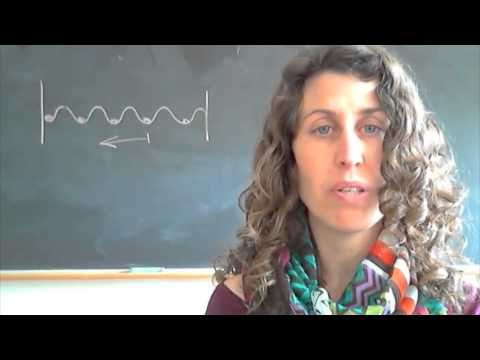

In [2]:
MoocVideo("gKZK9IGY9wo", src_location='3.1-intro', res='360')

# Hamiltonians with parameters

Previously, when studying the topology of systems supporting Majoranas (both the Kitaev chain and the nanowire), we were able to calculate topological properties by studying the bulk Hamiltonian $H(k)$.

There are two points of view on this Hamiltonian. We could either consider it a Hamiltonian of an infinite system with momentum conservation

$$H = H(k) |k\rangle\langle k|,$$

or we could equivalently study a finite system with only a small number of degrees of freedom (corresponding to a single unit cell), and a Hamiltonian which depends on some continuous periodic parameter $k$.

Of course, without specifying that $k$ is the real space momentum, there is no meaning in bulk-edge correspondence (since the edge is an edge in real space), but the topological properties are still well-defined.

Sometimes we want to know how a physical system changes if we slowly vary some parameters of the system, for example a bias voltage or a magnetic field. Because the parameters change with time, the Hamiltonian becomes time-dependent, namely

$$H = H(t).$$

The slow [adiabatic](https://en.wikipedia.org/wiki/Adiabatic_theorem) change of parameters ensures that if the system was initially in the ground state, it will stay in the ground state, so that the topological properties are useful.

A further requirement for topology to be useful is the *periodicity* of time evolution:

$$H(t) = H(t+T).$$

The period can even go to $\infty$, in which case $H(-\infty) = H(+\infty)$. The reasons for the requirement of periodicity are somewhat abstract. If the Hamiltonian has parameters, we're studying the topology of a *mapping* from the space of parameter values to the space of all possible gapped Hamiltonians. This mapping has nontrivial topological properties only if the space of parameter values is compact.

For us, this simply means that the Hamiltonian has to be periodic in time.

Of course, if we want systems with bulk-edge correspondence, then in addition to $t$ our Hamiltonian must still depend on the real space coordinate, or the momentum $k$.

# Quantum pumps

In the image below (source: Chambers's Encyclopedia, 1875, via Wikipedia) you see a very simple periodic time-dependent system, an Archimedes screw pump.

![](figures/Archimedes_screw.jpg)

The changes to the system are clearly periodic, and the pump works the same no matter how slowly we use it (that is, change the parameters), so it is an adiabatic tool.

What about a quantum analog of this pump? Turns out it is just as simple as you would think.

Let's take a one-dimensional region, coupled to two electrodes on both sides, and apply a strong sine-shaped confining potential in this region. As we move the confining potential, we drag the electrons captured in it.

So our system now looks like this:

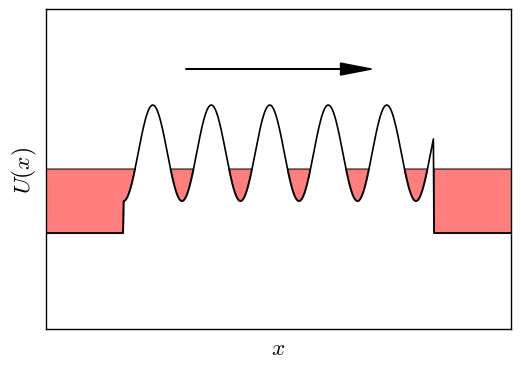

In [3]:
# Plot of the potential in the pumping system as a function of coordinate.
# Some part of the leads is shown with a constant potential.
# Regions with E < 0 should be shaded to emulate Fermi sea.
A = 0.6
L = 10
lamb = (10 / 5.3) / (2 * np.pi)
mu = -0.4
mu_lead = -0.8


def f(x):
    if x < 0.0:
        return mu_lead
    if x >= 0.0 and x <= L:
        return mu + A * (1.0 - np.cos(x / lamb))
    if x > L:
        return mu_lead

x = np.linspace(-5, 15, 1000)
y = [f(i) for i in x]

plt.figure(figsize=(6, 4))
plt.plot(x, y, 'k', lw=1.2)

plt.xlim(-2.5, 12.5)
plt.ylim(-2, 2)

y = [i if i <= 0 else 0 for i in y]
plt.fill_between(x, y, 0, color='r', where=np.array(y) <
                 0.0, alpha=0.5, edgecolor='k', lw='1.5')

plt.arrow(2.0, 1.25, 5, 0, head_width=0.15, head_length=1.0, fc='k', ec='k')

plt.xlabel('$x$')
plt.ylabel('$U(x)$')
plt.xticks([])
plt.yticks([])
plt.show()

It is described by the Hamiltonian

$$H(t) = \frac{k^2}{2m} + A [1 - \cos(x/\lambda + 2\pi t/T)].$$

As we discussed, if we change $t$ very slowly, the solution will not depend on how fast $t$ varies.

When $A \gg 1 /m \lambda^2$ the confining potential is strong, and additionally if the chemical potential $\mu \ll A$, the states bound in the separate minima of the potential have very small overlap.

The potential near the bottom of each minimum is approximately quadratic, so the Hamiltonian is that of a simple Harmonic oscillator. This gives us discrete levels of the electrons with energies $E_n = (n + \tfrac{1}{2})\omega_c$, with $\omega_c = \sqrt{A/m\lambda^2}$ the oscillator frequency.

We can quickly check how continuous bands in the wire become discrete evenly spaced bands as we increase $A$:

b':HoloMap   [$A$]\n   :Path   [$k$,$E$]'
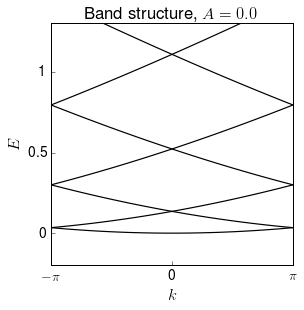
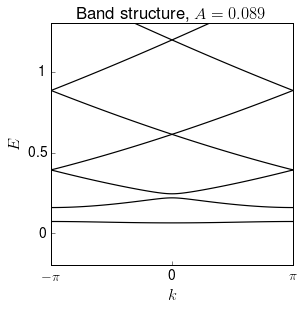
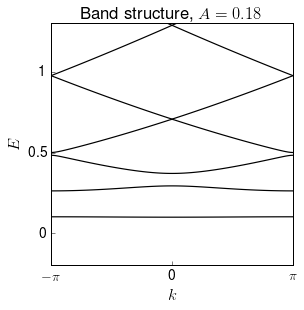
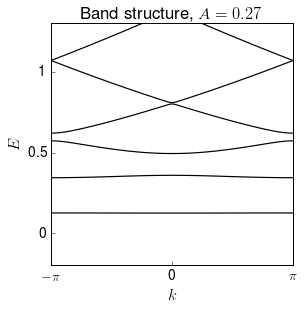
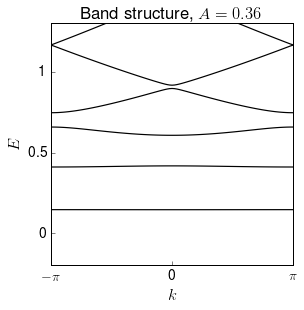
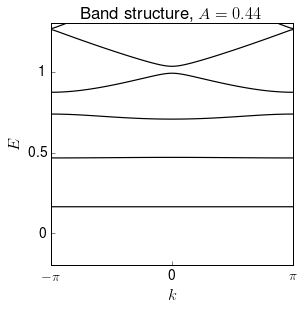
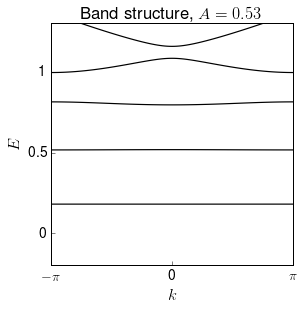
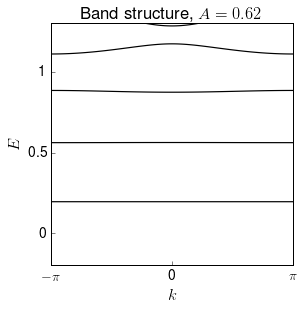
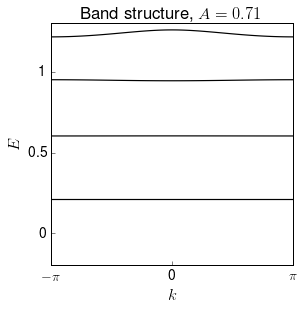
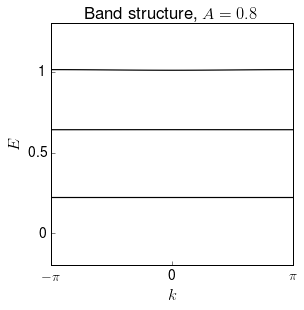

In [4]:
p = SimpleNamespace(t=1, mu=0.0, phase=0.0, A=None)
sys = ts_modulated_wire(L=17)

def title(p):
    return "Band structure, $A={:.2}$".format(p.A)

kwargs = {'ylims': [-0.2, 1.3],
          'xticks': pi_ticks,
          'yticks': [0, 0.5, 1.0],
          'xdim': r'$k$',
          'ydim': r'$E$',
          'k_x': np.linspace(-np.pi, np.pi, 101),
          'title': title}


holoviews.HoloMap({p.A: spectrum(sys, p, **kwargs) for p.A in np.linspace(0, 0.8, 10)}, kdims=[r'$A$'])

So unless $\mu = E_n$ for some $n$, each minimum of the potential contains an integer number of electrons $N$.

Electron wave functions from neighboring potential minima do not overlap, so when we change the potential by one time period, we move exactly $N$ electrons.

In [5]:
question = "Why are some levels in the band structure flat while some are not?"
answers = ["The flat levels are the ones whose energies are not sensitive to the offset of confining potential.",
           "Destructive interference of the wave functions in neighboring minima suppresses the dispersion.",
           "The flat levels are localized deep in the potential minima, "
           "so the bandwidth is exponentially small.",
           "The flat levels correspond to filled states, and the rest to empty states."]
explanation = ("The dispersion of the bands in a perodic potential appears "
               "when the wave functions from neighboring minima overlap.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=2, explanation=explanation)

MoocMultipleChoiceAssessment(**{'max_attempts': 2, 'correct_answer': 2, 'display_name': 'Question', 'question': 'Why are some levels in the band structure flat while some are not?', 'answers': ['The flat levels are the ones whose energies are not sensitive to the offset of confining potential.', 'Destructive interference of the wave functions in neighboring minima suppresses the dispersion.', 'The flat levels are localized deep in the potential minima, so the bandwidth is exponentially small.', 'The flat levels correspond to filled states, and the rest to empty states.'], 'explanation': 'The dispersion of the bands in a perodic potential appears when the wave functions from neighboring minima overlap.'})

# Quantization of pumped charge

As we already learned, integers are important, and they could indicate that something topological is happening.

At this point we should ask ourselves these questions: Is the number of electrons $N$ pumped per cycle topological, or can we pump any continuous amount of charge? How important is it that the potential well of the pump is deep?

### Thought experiment

To simplify the counting let's "dry out" the pump: We can define a procedure that empties the middle region, and pushes $n_L$ extra electrons to the left and $n_R$ electrons to the right.

For example, we can do this:

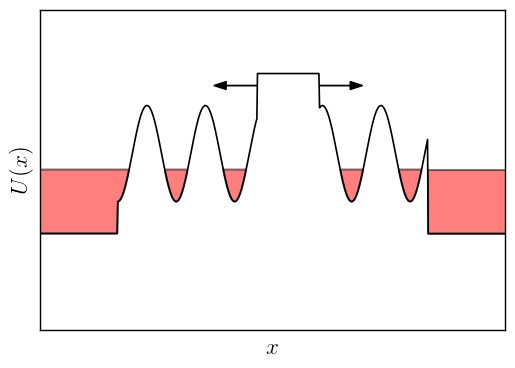

In [6]:
# Same plot as above, but now with an extra rectangular barrier in the
# middle, and with arrows both ways showing that the barrier widens.

# Plot of the potential in the pumping system as a function of coordinate.
# Some part of the leads is shown with a constant potential.
# Regions with E < 0 should be shaded to emulate Fermi sea.

# Plot of the potential in the pumping system as a function of coordinate.
# Some part of the leads is shown with a constant potential.
# Regions with E < 0 should be shaded to emulate Fermi sea.
A = 0.6
L = 10
lamb = (10 / 5.3) / (2 * np.pi)
mu = -0.4
mu_lead = -0.8
a = 4.5
b = 6.5
top = 1.2


def f(x):
    if x < 0.0:
        return mu_lead
    if x >= 0.0 and x <= a:
        return mu + A * (1.0 - np.cos(x / lamb))
    if x > a and x < b:
        return top
    if x >= b and x <= L:
        return mu + A * (1.0 - np.cos(x / lamb))
    if x > L:
        return mu_lead


x = np.linspace(-5, 15, 1000)
y = [f(i) for i in x]

plt.figure(figsize=(6, 4))
plt.plot(x, y, 'k', lw=1.2)
plt.xlim(-2.5, 12.5)
plt.ylim(-2, 2)
y = [i if i <= 0 else 0 for i in y]
plt.fill_between(x, y, 0, color='r', where=np.array(y) <
                 0.0, alpha=0.5, edgecolor='k', lw='1.5')
plt.arrow(a, 1.05, -1, 0, head_width=0.1, head_length=0.4, fc='k', ec='k')
plt.arrow(b, 1.05, +1, 0, head_width=0.1, head_length=0.4, fc='k', ec='k')
plt.xlabel('$x$')
plt.ylabel('$U(x)$')
plt.xticks([])
plt.yticks([])
plt.show()

A reverse of this procedure does the reverse of course, so it reduces the number of charges on the left and right sides.

Now here comes the trick:

1. When the middle region is emptied, the two sides are completely disconnected, and so the number of electrons on either side must be integer for every eigenstate of the Hamiltonian.

2. Next, if we performed the manipulation adiabatically, then if we start in an eigenstate of the Hamiltonian, we will also end in an eigenstate of the Hamiltonian. This is a consequence of the adiabatic theorem.

3. In light of 1. and 2., we conclude that in the process of drying the middle out, we pumped an integer number of charges.

4. Finally, adiabatic manipulation is only possible if the Hamiltonian stays gapped at all times.

Bonus: In our argument we didn't use the shape or the strength of the potential, so it applies universally to any possible pump.

So without doing any calculations, we can conclude that:

> The number of electrons pumped per cycle of a quantum pump is an integer as long as
> the bulk of the pump is gapped. Therefore it is a **topological invariant**.

# Counting electrons through reflection.

The expression for the pumped charge in terms of the bulk Hamiltonian $H(k, t)$ is complicated.

It's an integral over both $k$ and $t$, called a **Chern number** or in other sources a TKNN integer. Its complexity is beyond the scope of our course, but is extremely important, so we will have to study it... next week.

There is a much simpler way to calculate the same quantity using scattering formalism. From the previous two weeks, recall that we may infer the presence or absence of Majoranas at an end of a system by calculating either $Q = \textrm{sign}[\textrm{Pf}\,H(0)\,\textrm{Pf}\,H(\pi)]$ or $Q=\textrm{sign}\det r$, where $r$ is the reflection matrix from one end of the Majorana wire.

In order to derive the scattering expression, we need to understand how the pumped charge manifests in the reflection matrix.

Let's start from the case when there's just one mode in the reservoir. We'll count the charge pumped by making the reservoir finite but very large.

Now all the levels in the reservoir are quantized, and are standing waves, so they are equal weight superpositions of waves going to the left $\psi_L$ and to the right $\psi_R$,

$$
\psi_n = \psi_L(x) + \psi_R(x) \propto \exp(ik_n x) + \exp(-ik_n x + i\phi),
$$

where the wave number $k_n$ is of course a function of energy. The relative phase shift $\phi$ is necessary to satisfy the boundary condition at $x=0$, where $\psi_L = r \psi_R$, and so $\exp(i \phi) = r$. The energies of the levels are determined by requiring that the phases of $\psi_L$ and $\psi_R$ also match at $x = -L$.

Now, what happens when we pump one extra charge into the reservoir? All the energy levels are shifted up by one, that is $E_n \rightarrow E_{n+1}$, and accordingly the wave functions also change $\psi_n \rightarrow \psi_{n+1}$.

> We conclude that the charge can only be pumped as the reflection phase $\phi$ advances by $2\pi$.

It's very easy to generalize our argument to many modes. For that we just need to sum all of the reflection phase shifts, which means we need to look at the phase of $\det r$.

We conclude that there's a very compact relation between charge $dq$ pumped by an infinitesimal change of an external parameter and the change in reflection matrix $dr$:

$$
dq = \frac{r^\dagger dr }{ 2 \pi i}.
$$

While we proved this relation only for the case when there is no transmission from the reservoir, and $r$ is a unitary matrix, written in this form it also holds if there is some transmission.

Let's check if this expression holds to our expectations. If $||r||=1$, this is just the number of times the phase of $\det r$ winds around zero, and it is certainly an integer, as we expected.

# Applying the topological invariant

We're left with a simple exercise.

We know now how to calculate the pumped charge during one cycle, so let's just see how it works in practice.

The scattering problem in 1D can be solved quickly, so let's calculate the pumped charge as a function of time for different values of the chemical potential in the pump.

:Layout
   .Overlay.Band_structure_comma_A_equals_0_full_stop_6 :Overlay
      .Path.Band_structure_comma_A_equals_0_full_stop_6 :Path   [$k$,$E$]
      .HLine.I                                          :HLine   [x,y]
      .HLine.II                                         :HLine   [x,y]
      .HLine.III                                        :HLine   [x,y]
      .HLine.IV                                         :HLine   [x,y]
   .Q.Pumped_charge                                     :Overlay
      .Q.Reverse_over_mu_equals_0_full_stop_1 :Path   [$t/T$,$q/e$]
      .Q.Reverse_over_mu_equals_0_full_stop_3 :Path   [$t/T$,$q/e$]
      .Q.Reverse_over_mu_equals_0_full_stop_6 :Path   [$t/T$,$q/e$]
      .Q.Reverse_over_mu_equals_0_full_stop_9 :Path   [$t/T$,$q/e$]
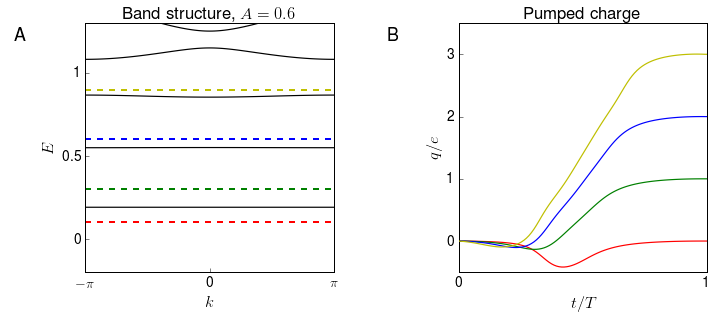

In [7]:
%%opts Path.Q (color=Cycle(values=['r', 'g', 'b', 'y']))
%%opts HLine (color=Cycle(values=['r', 'g', 'b', 'y']) linestyle='--')

def plot_charge(mu):
    energy = 0.0
    phases = np.linspace(0, 2*np.pi, 100)
    p = SimpleNamespace(t=1, mu=mu, mu_lead=mu, A=0.6, omega= .3)
    sys = modulated_wire(L=100).finalized()
    rs = [kwant.smatrix(sys, energy, args=[p]).submatrix(0, 0) for p.phase in phases]
    wn = -total_charge(rs)
    title = '$\mu={:.2}$'.format(mu)
    kdims = [r'$t/T$', r'$q/e$']
    plot = holoviews.Path((phases / (2 * np.pi), wn), kdims=kdims, label=title, group='Q')
    return plot[:, -0.5:3.5](plot={'xticks': [0, 1], 'yticks': [0, 1, 2, 3]})


kwargs = {'ylims': [-0.2, 1.3],
          'xticks': pi_ticks,
          'yticks': [0, 0.5, 1.0],
          'xdim': r'$k$',
          'ydim': r'$E$',
          'k_x': np.linspace(-np.pi, np.pi, 101),
          'title': lambda p: "Band structure, $A={:.2}$".format(p.A)}

p = SimpleNamespace(t=1, mu=0.0, phase=0.0, A=0.6)
sys = ts_modulated_wire(L=17)
mus = [0.1, 0.3, 0.6, 0.9]
HLines = holoviews.Overlay([holoviews.HLine(mu) for mu in mus])
spectrum(sys, p, **kwargs) * HLines + holoviews.Overlay([plot_charge(mu) for mu in mus]).relabel('Pumped charge')

In the left plot, we show the band structure, where the different colors correspond to different chemical potentials. The right plot shows the corresponding pumped charge. During the pumping cycle the charge may change, and the relation between the offset $\phi$ of the potential isn't always linear. However we see that after a full cycle, the pumped charge exactly matches the number of filled levels in a single potential well.

As a final mental exercise about pumps, let's think about what happens if we disconnect the leads and consider the spectrum of a closed system.

As the periodic potential moves, it tries to increase the energies of all the states at the right of the system and reduce the energy of all the states to the left (that's what pumping does after all).

So there should be states crossing the bulk band gap. Let's see if it's true.

b':Path   [$t/T$,$E$]'
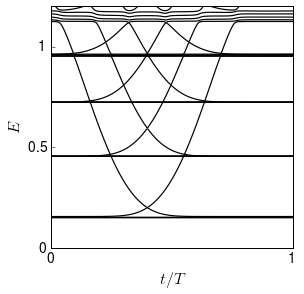

In [8]:
p = SimpleNamespace(t=1, mu=0.0, mu_lead=0, A=0.6, omega=0.3, phase=None)
sys = modulated_wire(L=110).finalized()
phases = np.linspace(0, 2*np.pi, 251)
en = [np.linalg.eigvalsh(sys.hamiltonian_submatrix(args=[p])) for p.phase in phases]
en = np.array(en)
ticks = {'xticks': [0, 1], 'yticks': [0, 0.5, 1]}
kdims = [r'$t/T$', r'$E$']
holoviews.Path((phases / (2*np.pi), en), kdims=kdims)[:, 0:1.2](plot=ticks)

Indeed, the levels in the bulk stay flat and have a high degeneracy, but we see that there are also single levels that get pushed across the gap. Since the bulk is homogeneous, these states have to be localized at the edge.

Of course, since we have a finite system, the charge cannot be pumped forever from one end into the other. So the pumping breaks down when you see the edge states crossing the bulk bands. At these moments the charge can flow back through the bulk.

In [9]:
question = ("What happens to the dependence of the reflection phase shift on time if we "
            "remove one of the reservoirs and leave the other one?")
answers = ["It becomes constant.",
           "For most of the cycle it stays the same, but there appear "
           "sharp jumps such that the total winding becomes zero.",
           "Nothing changes, since the two ends of the pump are "
           "far apart from each other, and the pump is not conducting.",
           "The reflection phase gets a new time dependence with zero winding, unrelated to the original one."]
explanation = ("The total pumped charge must become equal to zero since there's nowhere to place the charge, but "
               "since the pump is insulating, the phase cannot change "
               "for most of the cycle unless a sharp resonance appears")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'max_attempts': 2, 'correct_answer': 1, 'display_name': 'Question', 'question': 'What happens to the dependence of the reflection phase shift on time if we remove one of the reservoirs and leave the other one?', 'answers': ['It becomes constant.', 'For most of the cycle it stays the same, but there appear sharp jumps such that the total winding becomes zero.', 'Nothing changes, since the two ends of the pump are far apart from each other, and the pump is not conducting.', 'The reflection phase gets a new time dependence with zero winding, unrelated to the original one.'], 'explanation': "The total pumped charge must become equal to zero since there's nowhere to place the charge, but since the pump is insulating, the phase cannot change for most of the cycle unless a sharp resonance appears"})

# Quantized charge and scattering invariant

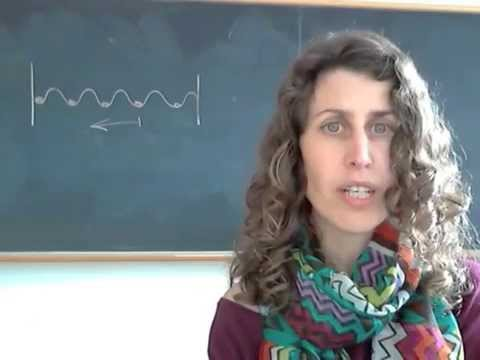

In [10]:
MoocVideo("6lXRAZ7hv7E", src_location='3.1-summary', res='360')

**Questions about what you learned? Ask them below**

In [11]:
MoocDiscussion('Questions', 'Quantum pumps')

MoocDiscussion(**{'discussion_category': 'Questions', 'discussion_target': 'Quantum pumps', 'discussion_id': 'b3f3e83f9f56270bf9803bc16fe7163f', 'display_name': 'Quantum pumps'})